In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import functools as ft

from numpy.ma.core import shape

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
XY = np.loadtxt('dane.data')

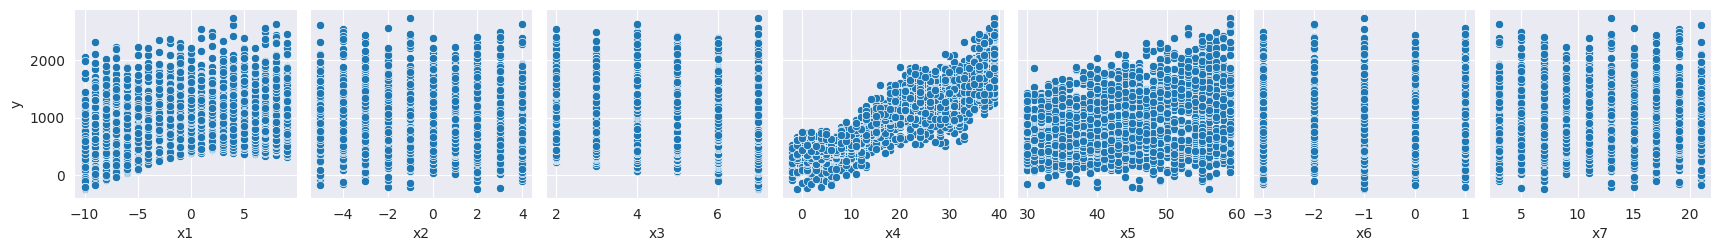

In [3]:
df = pd.DataFrame(data=XY, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'y'])
grid = sns.pairplot(df, x_vars=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], y_vars=['y'])

<Axes: >

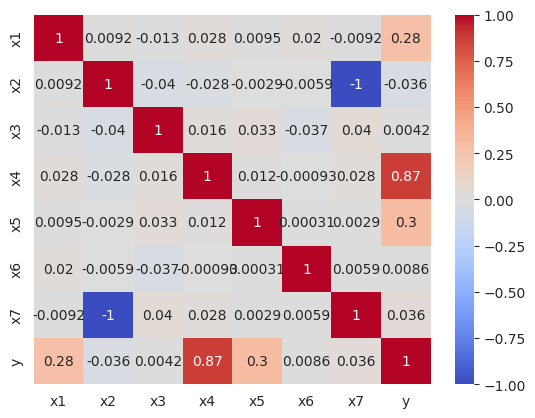

In [4]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

> x1, x4 i x5 układają się w jakąś prostą względem y \
> reszta danych pewnie potrzebuje jakichś transformacji (czym zajmiemy się później \
> x7 i x2 bardzo ciekawa korelacja

In [6]:
from utilz import divide_dataset

T = 10 # numer of iterations

# and some constants
EPOCHS = 3000
STEPS_TO_PLOT = 30
# STEPS_TO_PLOT should divide EPOCHS
EPSILON = 1e-5

datasets = []
for i in range(T):
    datasets.append(
        divide_dataset(
            XY.copy(),
            fractions_train_val_test=[0.6, 0.2, 0.2]))

> Mamy 10 losowych podziałów, tak żeby uśrednić wyniki

In [7]:
from utilz import run_linear_regression_model
from linear_regression import basic_analytic_linear_regression
from loss import ols

theta_Anal_NoIntercept_NotScaled, loss_Anal_NoIntercept_NotScaled, history_Anal_NoIntercept_NotScaled, training_Anal_NoIntercept_NotScaled =(
run_linear_regression_model(
    model=ft.partial(basic_analytic_linear_regression, intercept=False),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

print(f"Avg theta [Anal_NoIntercept_NotScaled]:\n{theta_Anal_NoIntercept_NotScaled}")
print(f"Test loss [Anal_NoIntercept_NotScaled]: {loss_Anal_NoIntercept_NotScaled}")

Avg theta [Anal_NoIntercept_NotScaled]:
[[  23.66481074]
 [-101.57214138]
 [  -6.4955352 ]
 [  39.05172156]
 [  18.73454601]
 [  -0.83903229]
 [ -49.51156464]]
Test loss [Anal_NoIntercept_NotScaled]: 14883.71537524796


In [8]:
from utilz import run_linear_regression_model
from linear_regression import basic_analytic_linear_regression
from loss import ols

theta_Anal_Intercept_NotScaled, loss_Anal_Intercept_NotScaled, history_Anal_Intercept_NotScaled, training_Anal_Intercept_NotScaled =(
run_linear_regression_model(
    model=ft.partial(basic_analytic_linear_regression, intercept=True),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

print(f"Avg theta [Anal_Intercept_NotScaled]:\n{theta_Anal_Intercept_NotScaled}")
print(f"Test loss [Anal_Intercept_NotScaled]: {loss_Anal_Intercept_NotScaled}")

Avg theta [Anal_Intercept_NotScaled]:
[[-22.05725652]
 [ 23.66481074]
 [-97.5617311 ]
 [ -6.4955352 ]
 [ 39.05172156]
 [ 18.73454601]
 [ -0.83903229]
 [-47.5063595 ]]
Test loss [Anal_Intercept_NotScaled]: 14883.715375247648


> Nie ma różnicy między intercept i bez interceptu \
> Być może ma to związek, z tym że x1, x4, i x5 przechodzą przez 0

> Szybko sprawdźmy ze SciKit-learn poprawność

In [9]:
from utilz import run_linear_regression_model
from sklearn.linear_model import LinearRegression
from loss import ols

model = LinearRegression(fit_intercept=False)
theta_SciKit_NoIntercept_NotScaled, loss_SciKit_NoIntercept_NotScaled, _, _ = run_linear_regression_model(
    model=lambda X, y, X_val, y_val:
        (model.fit(X, y).coef_.T, [], []),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)

model = LinearRegression(fit_intercept=True)
theta_SciKit_Intercept_NotScaled, loss_SciKit_Intercept_NotScaled, _, _ = run_linear_regression_model(
    model=lambda X, y, X_val, y_val:
        (np.c_[model.fit(X, y).intercept_, model.coef_].T, [], []),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)

In [10]:
print(f"Test loss [Anal_Intercept_NotScaled]: {loss_Anal_Intercept_NotScaled}")
print(f"Test loss [SciKit_Intercept_NotScaled]: {loss_SciKit_Intercept_NotScaled}")
print(f"Test loss [Anal_NoIntercept_NotScaled]: {loss_Anal_NoIntercept_NotScaled}")
print(f"Test loss [SciKit_NoIntercept_NotScaled]: {loss_SciKit_NoIntercept_NotScaled}")
print("-----------------------------")
print("Left: Analytic NotScaled, Right: SciKit NotScaled")
print("------------Intercept-------------")
print(np.hstack((theta_Anal_Intercept_NotScaled, theta_SciKit_Intercept_NotScaled)))
print("Left: Analytic NotScaled, Right: SciKit NotScaled")
print("-----------NoIntercept------------")
print(np.hstack((theta_Anal_NoIntercept_NotScaled, theta_SciKit_NoIntercept_NotScaled)))

Test loss [Anal_Intercept_NotScaled]: 14883.715375247648
Test loss [SciKit_Intercept_NotScaled]: 14883.715375247619
Test loss [Anal_NoIntercept_NotScaled]: 14883.71537524796
Test loss [SciKit_NoIntercept_NotScaled]: 14883.715375247597
-----------------------------
Left: Analytic NotScaled, Right: SciKit NotScaled
------------Intercept-------------
[[-2.20572565e+01 -5.55842864e+02]
 [ 2.36648107e+01  2.36648107e+01]
 [-9.75617311e+01 -5.09802419e-01]
 [-6.49553520e+00 -6.49553520e+00]
 [ 3.90517216e+01  3.90517216e+01]
 [ 1.87345460e+01  1.87345460e+01]
 [-8.39032286e-01 -8.39032286e-01]
 [-4.75063595e+01  1.01960484e+00]]
Left: Analytic NotScaled, Right: SciKit NotScaled
-----------NoIntercept------------
[[  23.66481074   23.66481074]
 [-101.57214138 -101.57214138]
 [  -6.4955352    -6.4955352 ]
 [  39.05172156   39.05172156]
 [  18.73454601   18.73454601]
 [  -0.83903229   -0.83903229]
 [ -49.51156464  -49.51156464]]


> Wygląda na to, że wszystko się zgadza \
> W dalszej części nie widzę sensu, żeby nie używać interceptu, więc będą rozważane tylko modele z interceptem \
> Okej, czas na gradient

In [11]:
from utilz import run_linear_regression_model
from linear_regression import GD_OLS_finite_difference_linear_regression
from linear_regression import GD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_GD_FD_NotScaled, loss_GD_FD_NotScaled, _, _ =(
run_linear_regression_model(
    ft.partial(
        GD_OLS_finite_difference_linear_regression,
        alpha=0.0001,
        epochs=EPOCHS,
        epsilon=EPSILON),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

theta_GD_NotScaled, loss_GD_NotScaled, history_GD_NotScaled, training_GD_NotScaled =(
run_linear_regression_model(
    ft.partial(
        GD_linear_regression,
        grad=GD_OLS,
        alpha=0.0001,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

In [12]:
print(f"Test loss [GD_FD_NotScaled]: {loss_GD_FD_NotScaled}")
print(f"Test loss [GD_NotScaled]: {loss_GD_NotScaled}")
print("-----------------------------")
print("Left: GD_FD NotScaled, Right: GD NotScaled")
print(np.hstack((theta_GD_FD_NotScaled, theta_GD_NotScaled)))


Test loss [GD_FD_NotScaled]: 16019.32066224401
Test loss [GD_NotScaled]: 16019.320661642963
-----------------------------
Left: GD_FD NotScaled, Right: GD NotScaled
[[ -4.16002305  -4.16002306]
 [ 23.99525669  23.99525669]
 [-17.34229611 -17.34229612]
 [-15.16429838 -15.16429836]
 [ 37.43039387  37.43039387]
 [ 11.36606135  11.36606135]
 [  2.18300526   2.18300526]
 [-11.07566144 -11.07566144]]


> Cieszymy się, potrafię liczyć gradient \
> Poszukajmy najlepszego parametru alpha
>
> [mała uwaga co do tego, jeśli da się alpha * 1/m to działa z sumą, inaczej eksplozja, co ma sens]

In [13]:
from utilz import search_alpha
from linear_regression import GD_linear_regression
from loss import ols
from gradient import GD_OLS

alphas = [0.000001, 0.00001, 0.0001, 0.001]
search_alpha(
    model=ft.partial(GD_linear_regression, grad=GD_OLS, epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=False)

Alpha: 1e-06, validation loss 57739.68566462274
Alpha: 1e-05, validation loss 19570.969641279014
Alpha: 0.0001, validation loss 16460.205993935866
Alpha: 0.001, validation loss nan


In [14]:
alphas = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
search_alpha(
    model=ft.partial(GD_linear_regression, grad=GD_OLS, epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=False)

Alpha: 0.0002, validation loss 15855.610853438866
Alpha: 0.0003, validation loss 15547.028333862221
Alpha: 0.0004, validation loss 15364.387745782045
Alpha: 0.0005, validation loss 15261.581814338491
Alpha: 0.0006, validation loss 15211.593399983676
Alpha: 0.0007, validation loss 15195.398506661679
Alpha: 0.0008, validation loss 1.489060659724989e+194
Alpha: 0.0009, validation loss nan


> Jak widzimy, alpha = 0.0007 daje najlepsze wyniki \
> Spójrzmy na learning curve

In [15]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_GD_NotScaled, loss_GD_NotScaled, history_GD_NotScaled, training_GD_NotScaled =(
run_linear_regression_model(
    ft.partial(
        GD_linear_regression,
        grad=GD_OLS,
        alpha=0.0007,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

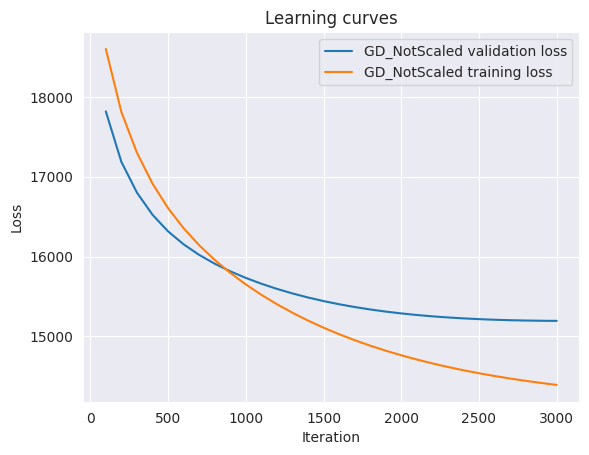

In [16]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_GD_NotScaled, ax = ax, label='GD_NotScaled validation loss')
sns.lineplot(x = steps, y = training_GD_NotScaled, ax = ax, label='GD_NotScaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Jak się zaraz okaże, standaryzacja cech znacząco przyspiesza zbieżność

In [17]:
from utilz import search_alpha
from linear_regression import GD_linear_regression
from loss import ols
from gradient import GD_OLS

alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
search_alpha(
    model=ft.partial(GD_linear_regression, grad=GD_OLS, epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=True)

Alpha: 0.0001, validation loss 335838.43686996785
Alpha: 0.001, validation loss 16942.634277634344
Alpha: 0.01, validation loss 15464.28070735973
Alpha: 0.1, validation loss 15464.280707360123
Alpha: 0.5, validation loss 15464.280707360125
Alpha: 1, validation loss 517976008.2309672


> No dobrze alpha = 0.1 i co z tego? Spójrzmy na learning curve

In [18]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_GD_Scaled, loss_GD_Scaled, history_GD_Scaled, training_GD_Scaled =(
run_linear_regression_model(
    ft.partial(
        GD_linear_regression,
        grad=GD_OLS,
        alpha=0.1,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

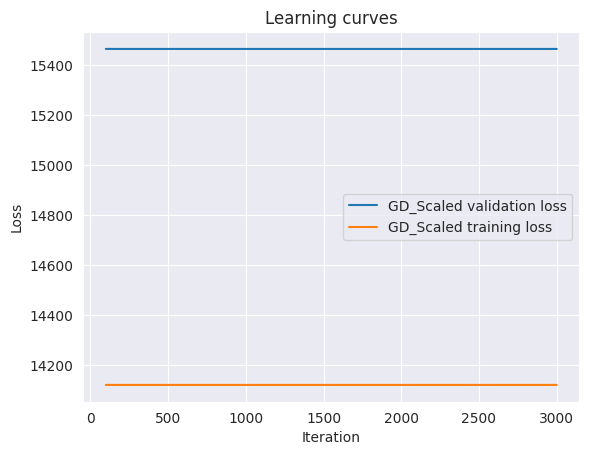

In [19]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_GD_Scaled, ax = ax, label='GD_Scaled validation loss')
sns.lineplot(x = steps, y = training_GD_Scaled, ax = ax, label='GD_Scaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Coś dziwnego prawda?

In [20]:
EPOCHS = 50
STEPS_TO_PLOT = 50

In [21]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_GD_Scaled, loss_GD_Scaled, history_GD_Scaled, training_GD_Scaled =(
run_linear_regression_model(
    ft.partial(
        GD_linear_regression,
        grad=GD_OLS,
        alpha=0.1,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

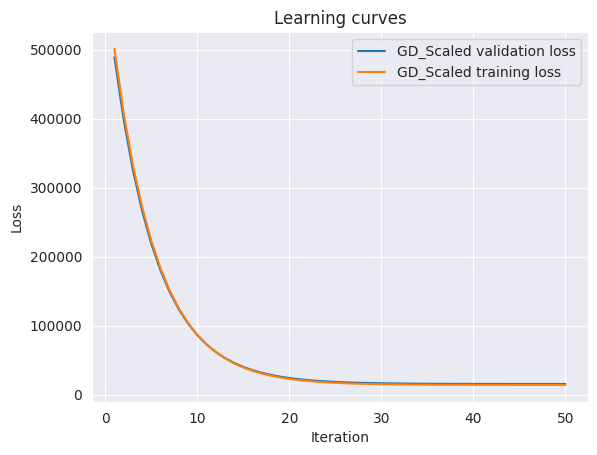

In [22]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_GD_Scaled, ax = ax, label='GD_Scaled validation loss')
sns.lineplot(x = steps, y = training_GD_Scaled, ax = ax, label='GD_Scaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Niesamowita zbieżność, bo gradient schodzi w każdą stronę równomiernie, dzięki standaryzacji

In [23]:
print(f"Validation loss [GD_Scaled]: {history_GD_Scaled[-1]}")
print(f"Validation loss [GD_NotScaled]: {history_GD_NotScaled[-1]}")

Validation loss [GD_Scaled]: 15485.943319131384
Validation loss [GD_NotScaled]: 15195.398506661677


> Czas na SGD <3

In [24]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_SGD_Scaled, loss_SGD_Scaled, history_SGD_Scaled, training_SGD_Scaled =(
run_linear_regression_model(
    ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.1,
        batch_size=32,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

In [25]:
print(f"Test loss [GD_Scaled]: {loss_GD_Scaled}")
print(f"Test loss [SGD_Scaled]: {loss_SGD_Scaled}")
print("-----------------------------")
print("Left: GD Scaled, Right: SGD Scaled")
print(np.hstack((theta_GD_Scaled, theta_SGD_Scaled)))

Test loss [GD_Scaled]: 14853.682654575812
Test loss [SGD_Scaled]: 15041.257731101034
-----------------------------
Left: GD Scaled, Right: SGD Scaled
[[ 9.65254603e+02  9.70071423e+02]
 [ 1.34360496e+02  1.37337229e+02]
 [-3.63800740e+00 -5.46589533e-01]
 [-1.06833712e+01 -1.40320601e+01]
 [ 4.59362066e+02  4.57521228e+02]
 [ 1.61917035e+02  1.60830751e+02]
 [-1.15817774e+00  4.64008614e-01]
 [ 3.63800740e+00  5.46589533e-01]]


> Wygląda jakby miało działać \
> Poszukajmy hiperparametrów

In [26]:
from utilz import search_alpha
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD_OLS

alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
search_alpha(
    model=ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        batch_size=32,
        epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=True)

Alpha: 0.0001, validation loss 414808.1277623578
Alpha: 0.001, validation loss 28530.447472488864
Alpha: 0.01, validation loss 15465.352812979501
Alpha: 0.1, validation loss 15575.811328351241
Alpha: 0.5, validation loss 18009.644356609213
Alpha: 1, validation loss 114696.06361233044


In [27]:
from utilz import search_batch_size
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD_OLS

batch_sizes = [1, 16, 32, 64, 128, 256, 512]
search_batch_size(
    model=ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.01,
        epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    batch_sizes=batch_sizes,
    standardize=True)

Batch size: 1, validation loss 16069.041970423603
Batch size: 16, validation loss 15470.831552313324
Batch size: 32, validation loss 15474.389027902624
Batch size: 64, validation loss 15468.559160469134
Batch size: 128, validation loss 15499.087474270742
Batch size: 256, validation loss 19340.74993113857
Batch size: 512, validation loss 44173.69851260181


> alpha = 0.01, batch_size = 64 \
> Popatrzmy na wykresiki

In [29]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_SGD_Scaled, loss_SGD_Scaled, history_SGD_Scaled, training_SGD_Scaled =(
run_linear_regression_model(
    ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.01,
        batch_size=64,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

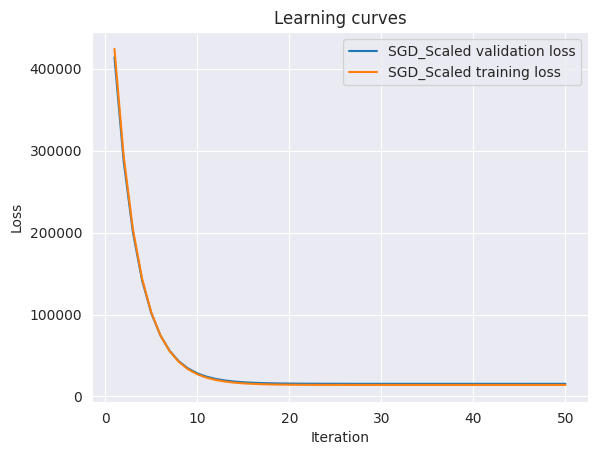

In [30]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_SGD_Scaled, ax = ax, label='SGD_Scaled validation loss')
sns.lineplot(x = steps, y = training_SGD_Scaled, ax = ax, label='SGD_Scaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Wydaje się, że zbiega szybciej niż GD

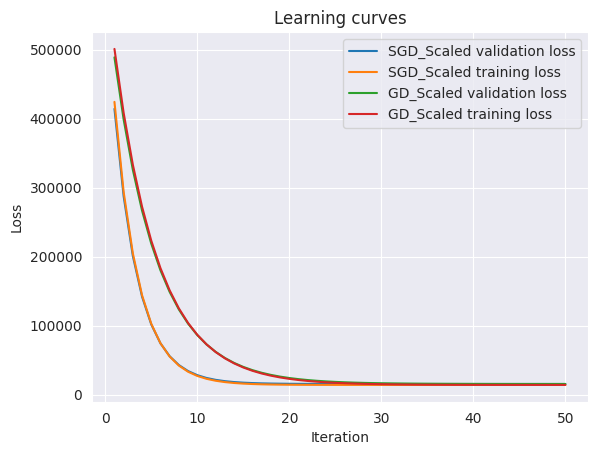

In [31]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_SGD_Scaled, ax = ax, label='SGD_Scaled validation loss')
sns.lineplot(x = steps, y = training_SGD_Scaled, ax = ax, label='SGD_Scaled training loss')
sns.lineplot(x = steps, y = history_GD_Scaled, ax = ax, label='GD_Scaled validation loss')
sns.lineplot(x = steps, y = training_GD_Scaled, ax = ax, label='GD_Scaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Możemy zerknąć już na test loss, nie będziemy ruszać tych modeli

In [32]:
print(f"Test loss [GD_Scaled]: {loss_GD_Scaled}")
print(f"Test loss [SGD_Scaled]: {loss_SGD_Scaled}")

Test loss [GD_Scaled]: 14853.682654575812
Test loss [SGD_Scaled]: 14886.037727361347


> Porównywalnie, musiało się gorzej wylosować, że się tak zdarzyło \
> Czas na regularyzacje, zostanę przy SGD, bo go bardzo lubię :) \
> Ale zanim SGD, przecież my umiemy rozwiązać to analitycznie

In [35]:
from utilz import run_linear_regression_model
from linear_regression import L2_analytic_linear_regression
from loss import ols

theta_Anal_L2, loss_Anal_L2, history_Anal_L2, training_Anal_L2 = run_linear_regression_model(
    model=ft.partial(L2_analytic_linear_regression,
               lambdaa=0.01,
               intercept=True,
               loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

print(f"Avg theta [Anal_L2]:\n{theta_Anal_L2}")
print(f"Test loss [Anal_L2]: {loss_Anal_L2}")

Avg theta [Anal_L2]:
[[970.25507923]
 [134.63800082]
 [ -3.64809552]
 [-10.98889822]
 [461.68421833]
 [162.77215302]
 [ -1.20589995]
 [  3.64809551]]
Test loss [Anal_L2]: 14883.572578363044


> Ponownie użyjemy SciKit-learn, żeby sprawdzić

In [36]:
from sklearn.linear_model import Ridge
from loss import ols
from utilz import run_linear_regression_model

model = Ridge(alpha=0.01, fit_intercept=True)
theta_SciKit_L2, loss_SciKit_L2, _, _ = run_linear_regression_model(
    model=lambda X, y, X_val, y_val:
        (np.r_[model.fit(X, y).intercept_, model.coef_].reshape(-1, 1), [], []),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)


In [37]:
print(f"Test loss [Anal_L2]: {loss_Anal_L2}")
print(f"Test loss [SciKit_L2]: {loss_SciKit_L2}")
print("-----------------------------")
print("Left: L2 Analytic, Right: L2 SciKit")
print(np.hstack((theta_Anal_L2, theta_SciKit_L2)))

Test loss [Anal_L2]: 14883.572578363044
Test loss [SciKit_L2]: 14883.572578371048
-----------------------------
Left: L2 Analytic, Right: L2 SciKit
[[970.25507923 970.25507923]
 [134.63800082 134.63800082]
 [ -3.64809552  -3.64809551]
 [-10.98889822 -10.98889822]
 [461.68421833 461.68421833]
 [162.77215302 162.77215302]
 [ -1.20589995  -1.20589995]
 [  3.64809551   3.64809551]]


> Klasa, wszystko się zgadza, poszukajmy dobrej lambdy

In [39]:
from utilz import search_lambdas
from linear_regression import L2_analytic_linear_regression
from loss import ols

lambdas = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
search_lambdas(
    model=ft.partial(
        L2_analytic_linear_regression,
        lambdaa=0.01,
        intercept=True,
        loss=ols),
    loss=ols,
    datasets=datasets,
    lambdas=lambdas,
    standardize=True)

Lambda: 0, validation loss 15464.280707360138
Lambda: 1e-05, validation loss 15464.280579995622
Lambda: 0.0001, validation loss 15464.27953133324
Lambda: 0.001, validation loss 15464.268929486894
Lambda: 0.01, validation loss 15464.162936301615
Lambda: 0.1, validation loss 15463.104001883656
Lambda: 1, validation loss 15452.614013490276


> Marginalne różnice, ale możemy sobie zobaczyć, czy otrzymamy ten sam wynik co zwykła regresja gdy lambda = 0

In [44]:
from utilz import run_linear_regression_model
from linear_regression import basic_analytic_linear_regression
from loss import ols

theta_Anal_Intercept_Scaled, loss_Anal_Intercept_Scaled, history_Anal_Intercept_Scaled, _ = (
    run_linear_regression_model(
    model=ft.partial(basic_analytic_linear_regression, intercept=True),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

print(f"Val loss [Anal_Intercept_Scaled] {history_Anal_Intercept_Scaled}")

Val loss [Anal_Intercept_Scaled] 15464.280707360138


> Dokładnie to samo, cieszymy się \
> Możemy też zobaczyć czy norma thety się zmniejszy dla lambda = 1 \
> i przy okazji porównamy test loss, bo nic więcej się nie da zrobić

In [45]:
from utilz import run_linear_regression_model
from linear_regression import L2_analytic_linear_regression
from loss import ols

theta_Anal_L2, loss_Anal_L2, history_Anal_L2, training_Anal_L2 = run_linear_regression_model(
    model=ft.partial(L2_analytic_linear_regression,
               lambdaa=1,
               intercept=True,
               loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

In [46]:
print(f"Test loss [Anal_L2]: {loss_Anal_L2}")
print(f"Test loss [Anal_Intercept_Scaled]: {loss_Anal_Intercept_Scaled}")
print("-----------------------------")
print(f"Norm [Anal_L2]: {np.linalg.norm(theta_Anal_L2[1:])}")
print(f"Norm [Anal_Intercept_Scaled]: {np.linalg.norm(theta_Anal_Intercept_Scaled[1:])}")


Test loss [Anal_L2]: 14869.540343238823
Test loss [Anal_Intercept_Scaled]: 14883.715375247612
-----------------------------
Norm [Anal_L2]: 507.447560376791
Norm [Anal_Intercept_Scaled]: 507.86569124022213


> Powiedzmy, że wszystko się zgadza, chociaż różnice są marginalne

In [67]:
EPOCHS = 100
STEPS_TO_PLOT = 100
# for now, maybe L2 will need longer to converge

In [88]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD_OLS_L2

theta_L2, loss_L2, history_L2, training_L2 = run_linear_regression_model(
    model=ft.partial(
        SGD_linear_regression,
        grad=ft.partial(GD_OLS_L2, lambdaa=1),
        alpha=0.001,
        epochs=EPOCHS,
        batch_size=64,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

In [91]:
print(f"Val loss [L2]: {history_L2[-1]}")
print(f"Val loss [Anal_L2]: {history_Anal_L2[-1]}")
print(f"Norm [L2]: {np.linalg.norm(theta_L2[1:])}")

Val loss [L2]: 15163.318968128928
Val loss [Anal_L2]: 15452.614013490276
Norm [L2]: 491.6033482851845


> Znowu SGD pozytywnie zaskakuje \
> Zobaczmy wykres

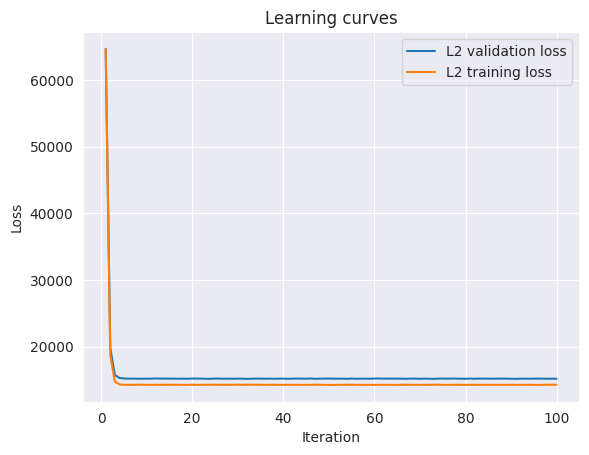

In [90]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_L2, ax = ax, label='L2 validation loss')
sns.lineplot(x = steps, y = training_L2, ax = ax, label='L2 training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Mieszane uczucia co do tego SGD + L2 \
> Było, żle konieczna tam jest np.sum a nie np.mean w gradiencie, inną wagę ma wtedy norma \
> alpha została wyznaczona tym razem ręcznie \
> Zróbmy lasso, liczę, że wyzeruje nieistotne cechy

In [183]:
EPOCHS = 100
STEPS_TO_PLOT = 100
# for now, maybe L1 will need longer to converge

In [191]:
from utilz import run_linear_regression_model
from linear_regression import L1_linear_regression
from loss import ols

theta_L1, loss_L1, history_L1, training_L1 = run_linear_regression_model(
    model=ft.partial(
        L1_linear_regression,
        lambdaa=0.1,
        epochs=EPOCHS,
        intercept=True,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

In [192]:
print(f"Avg theta [L1]:\n{theta_L1}")
print(f"Val loss [L1]: {loss_L1}")


Avg theta [L1]:
[[970.25507923]
 [134.63896566]
 [ -5.94743735]
 [-10.98901163]
 [461.6880045 ]
 [162.77346861]
 [ -1.20588038]
 [  1.34874315]]
Val loss [L1]: 14883.712534363945


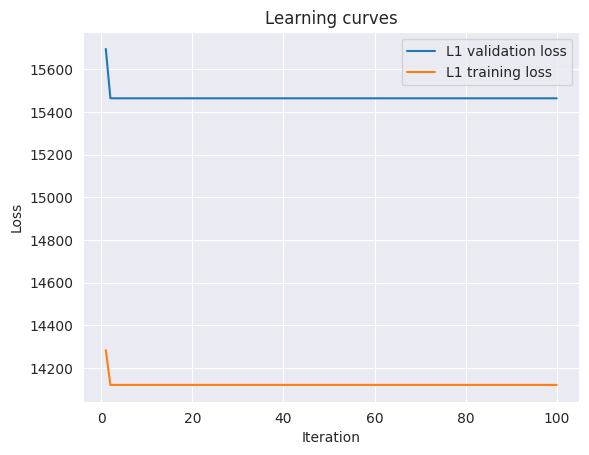

In [194]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)


fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_L1, ax = ax, label='L1 validation loss')
sns.lineplot(x = steps, y = training_L1, ax = ax, label='L1 training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Coś mi tu nie pasuje, zobaczmy SciKit

In [160]:
from sklearn.linear_model import Lasso
from loss import ols
from utilz import run_linear_regression_model

model = Lasso(alpha=0.01, fit_intercept=True)
theta_SciKit_L1, loss_SciKit_L1, _, _ = run_linear_regression_model(
    model=lambda X, y, X_val, y_val:
        (np.r_[model.fit(X, y).intercept_, model.coef_].reshape(-1, 1), [], []),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)


In [162]:
print(f"Avg theta [L1]:\n{theta_SciKit_L1}")
print(f"Val loss [L1]: {loss_SciKit_L1}")


Avg theta [L1]:
[[970.25507923]
 [134.62961363]
 [ -5.93758372]
 [-10.97825282]
 [461.67803869]
 [162.76353933]
 [ -1.19560369]
 [  1.34824968]]
Val loss [L1]: 14883.034418195395


> Zadziwiająco szybko zbiega